In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Read spectral library

In [3]:
from spectral.io import envi
fili = r"C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.pond.hdr"
spectra = envi.open(fili)
nspectra = len(spectra.names)
print nspectra

57


#Remove bad or spurious data

Many of the spectra are noisy beyond 1000 nanometers.  This likely results from insufficient averaging time during data collection: there is little energy in IR wavelength so measured photons will be noisy.  There are some other aspects of bad data - often in the first two wavebands.  

Spectra beyond 1000 nanometers are masked.  Suspect data at short wavelengths are also masked.

In [4]:
def qa_spectra(spectralLib):
    
    # Convert spectra to a masked array
    spectra_ma = np.ma.array(spectralLib.spectra)
    
    # If wavelength is not already a numpy array make it one
    wavelength = np.array(spectralLib.bands.centers)
    
    # Create mask for wavelength greater than 1000 nm
    mask = np.empty(spectra_ma.shape, dtype=bool)
    mask[:,:] = (wavelength > 1000.)[np.newaxis,:]
    
    # Apply mask
    spectra_ma = ma.masked_array(spectra_ma, mask=mask, fill_value=np.nan)
    
    # Mask spectral albedos greater than 0.99
    spectra_ma = ma.masked_array(spectra_ma, mask=(spectra_ma > 0.99))
    
    # For ice spectra there are cases where albedos for the first two wavebands are
    # too high to be believable.  I get rid of these by masking the first two wavebands of any
    # spectra where the first albedo is greater than the third waveband by 0.5
    mask = np.empty(spectra_ma.shape, dtype=bool)
    mask[:,:] = False
    tmp = (spectra_ma[:,0]-spectra_ma[:,2] > 0.05).filled(fill_value=False)
    mask[:,0] = tmp
    mask[:,1] = tmp

    # Apply this mask
    spectra_ma = ma.masked_array(spectra_ma, mask=mask)
    
    return spectra_ma

Do QC on spectra using wavelength and range based approaches

In [5]:
spectrama = qa_spectra(spectra)

#Clip to the 300 to 1000 nm band

We ignore spectra beyond 1000 nm as these are too noisy in the SHEBA data.  This is done before smoothing to avoid smoothing over missing values beyond 1000 nm

In [6]:
wavelength = np.array(spectra.bands.centers)
new_wavelength = wavelength[wavelength < 1000.]
new_spectrama = spectrama[:,wavelength < 1000.]

#Smooth the spectra

I use a simple moving average

In [7]:
def moving_average(x, window_len):
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = numpy.ones(window_len,'d')
    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len-1)*0.5:(-1)*(window_len-1)*0.5]

In [8]:
spectra_smooth = np.empty(new_spectrama.shape,dtype=new_spectrama.dtype)
for ispct in np.arange(0,new_spectrama.shape[0]):
    spectra_smooth[ispct,:] = moving_average(new_spectrama[ispct,:].filled(), 11)

C:\Users\apbarret\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#Fill missing values

If there are missing values in an array, fill then using a linear interpolation.  I use linear interp because missing values are often at begining or end of arrays so linear will extrapolate.

In [9]:
import scipy.interpolate as interp
spectra_filled = np.empty(spectra_smooth.shape, dtype=spectra_smooth.dtype)
for ispct in np.arange(0,spectra_smooth.shape[0]):
    x = new_wavelength
    if np.isnan(spectra_smooth[ispct,:]).any():
        y = spectra_smooth[ispct,:]
        f = interp.interp1d(x[np.isfinite(y)],y[np.isfinite(y)],kind='linear',
                    bounds_error=False,fill_value='extrapolate')
        spectra_filled[ispct,:] = f(x)
    else:
        spectra_filled[ispct,:] = spectra_smooth[ispct,:]

#Plot to check

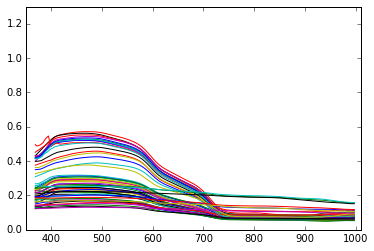

In [10]:
import matplotlib.pyplot as plt
plt.plot(new_wavelength,spectra_filled[0,:],'-b')
plt.xlim([350.,1010.])
plt.ylim([0.,1.3])
for ii in range(1,nspectra):
    plt.plot(new_wavelength,spectra_filled[ii,:].reshape(-1))

#Write to spectral library file

In [12]:
from spectral.io.envi import SpectralLibrary, gen_params
from shebaspectral import generate_library_header

header = generate_library_header(spectra_filled, new_wavelength, None, None, spectra.names)
params = gen_params(header)

from spectral.io.envi import SpectralLibrary
specLib = SpectralLibrary(spectra_filled, header, params)

filo = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.pond.filled"
specLib.save(filo)